<a href="https://colab.research.google.com/github/pranshu-raj-211/project-alphazero/blob/main/ganv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Resources used

- [deconvolution](https://distill.pub/2016/deconv-checkerboard/)
- [Compiling generator is unnecessary ](https://stackoverflow.com/questions/62303892/in-gan-is-it-necessary-to-compile-generator)
- [feature maps](https://www.baeldung.com/cs/cnn-feature-map)

In [1]:
from tensorflow import keras
from keras.layers import Dense, Dropout, Reshape, BatchNormalization, LeakyReLU, Conv2D, Flatten
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.datasets.mnist import load_data

(trainX, _), (_, _) = load_data()

print('Train', trainX.shape)

11490434/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28)


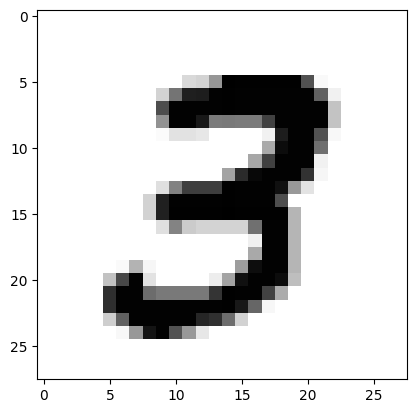

In [3]:
plt.imshow(trainX[7],cmap='gray_r')

In [4]:
from keras.optimizers import Adam

def build_discriminator(input_shape=(28,28,1)):
    model=keras.Sequential(
        [
            Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='same',input_shape=input_shape),
            LeakyReLU(),
            BatchNormalization(),
            Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='same'),
            LeakyReLU(),
            BatchNormalization(),
            Flatten(),
            Dense(1,activation='sigmoid')
        ]
    )

    optimizer=Adam(learning_rate=0.001,beta_1=0.8)
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    return model

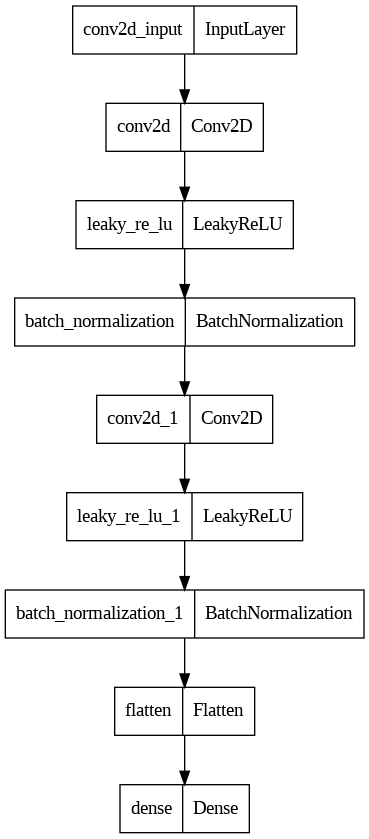

In [5]:
from keras.utils import plot_model

discriminator=build_discriminator()
plot_model(discriminator)

In [6]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 14, 14, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 64)          256       
 chNormalization)                                       

In [7]:
X=np.expand_dims(trainX,axis=3)
print(X.shape)
X[0].shape

(60000, 28, 28, 1)


(28, 28, 1)

In [8]:
X=X.astype('float32')
X=X/255.0

In [9]:
def get_real_samples(data,n_samples):
    idx=np.random.randint(0,len(data),n_samples)
    X=data[idx]
    y=np.ones(shape=n_samples)
    return X,y

In [10]:
def get_fake_samples(n_samples):
    '''sampling from a standard normal distribution'''
    X=np.random.randn(28*28*n_samples).reshape(n_samples,28,28,1)
    y=np.zeros(n_samples)
    return X,y

In [11]:
def train_discriminator(discriminator,dataset,n_iter=10,batch_size=64):
    half_batch_size=int(batch_size/2)
    # 40 iterations is good for a start, it fits the real data much better(<10) so there is a chance of massive overfit
    # how to mitigate this issue
    for i in range(n_iter):
        X_real,y_real=get_real_samples(X,n_samples=half_batch_size)
        real_loss,real_acc=discriminator.train_on_batch(X_real,y_real)
        X_fake,y_fake=get_fake_samples(n_samples=half_batch_size)
        fake_loss,fake_acc=discriminator.train_on_batch(X_fake,y_fake)
        print(f'iteration : {i},  real : {real_acc}, fake : {fake_acc}')

In [12]:
train_discriminator(discriminator,X)

iteration : 0,  real : 0.4375, fake : 0.5
iteration : 1,  real : 1.0, fake : 0.5
iteration : 2,  real : 1.0, fake : 0.5
iteration : 3,  real : 1.0, fake : 0.4375
iteration : 4,  real : 1.0, fake : 0.5
iteration : 5,  real : 1.0, fake : 0.53125
iteration : 6,  real : 1.0, fake : 0.5625
iteration : 7,  real : 1.0, fake : 0.59375
iteration : 8,  real : 1.0, fake : 0.6875
iteration : 9,  real : 1.0, fake : 0.71875


In [28]:
def build_generator(latent_space):
    model=keras.Sequential(
        [
            Dense(128*7*7, input_shape=(latent_space,)),
            LeakyReLU(0.2),
            Reshape((7,7,128)),
            keras.layers.Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'),
            LeakyReLU(0.2),
            keras.layers.Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'),
            LeakyReLU(0.2),
            Conv2D(1,(7,7),padding='same',activation='sigmoid')
        ]
    )

    return model

# generator=build_generator(100)
# generator.summary()

[Compiling generator is unnecessary ](https://stackoverflow.com/questions/62303892/in-gan-is-it-necessary-to-compile-generator)

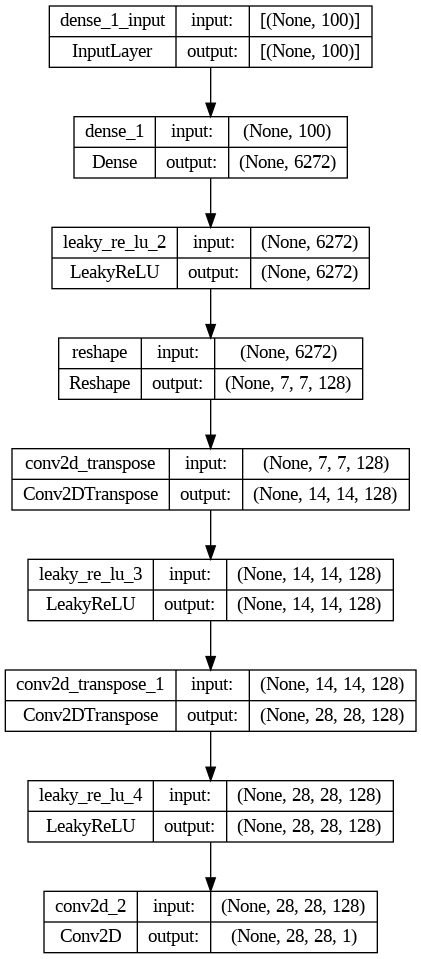

In [14]:
# plot_model(generator,show_shapes=True)

In [15]:
def generate_latent_points(latent_dim, n_samples):
    x_input=np.random.randn(latent_dim*n_samples).reshape((n_samples, latent_dim))
    return x_input

In [16]:
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input=generate_latent_points(latent_dim, n_samples)
    X=generator.predict(x_input)
    y=np.zeros((n_samples, 1))
    return X, y

1/1 [==============================] - 1s 508ms/step


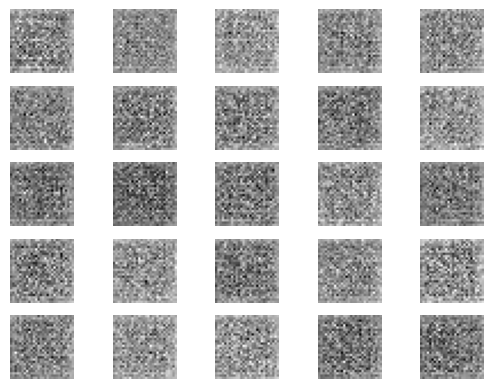

In [17]:
latent_dim=100
n_samples=25
generatorv2=build_generator((latent_dim,))
X, y = generate_fake_samples(generatorv2, latent_dim, n_samples)

for i in range(n_samples):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(X[i, : , : , 0],cmap='gray_r')

# am i observing the checkerboard effect here?

In [18]:
def build_GAN(generator, discriminator):
    discriminator.trainable=False   # freeze the discriminator, update to weights allowed only when it is trained in a standalone manner
    model=keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    optimizer=Adam(learning_rate=0.002, beta_1=0.8)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model

In [19]:
generator.output_shape

(None, 28, 28, 1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential (Sequential)     (None, 1)                 41217     
                                                                 
Total params: 1205506 (4.60 MB)
Trainable params: 1164289 (4.44 MB)
Non-trainable params: 41217 (161.00 KB)
_________________________________________________________________


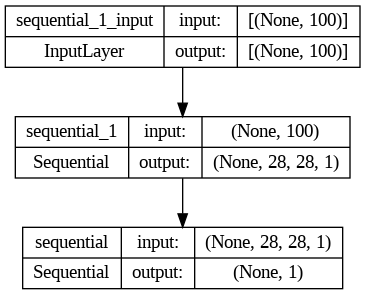

In [20]:
gan_model = build_GAN(generator, discriminator)
gan_model.summary()
plot_model(gan_model, show_shapes=True)

In [21]:
def train_gan(gan, latent_dim, epochs=100, batch_size=256):
    for i in range(epochs):
        x_gan=generate_latent_points(latent_dim,batch_size)
        y_gan=np.zeros((batch_size,1))
        gan.train_on_batch(x_gan,y_gan)

In [23]:
def save_plot(samples, epoch, grid_size = 10):
    for i in range(grid_size ** 2):
        plt.subplot(grid_size,grid_size,i+1)
        plt.axis('off')
        plt.imshow(samples[i,:,:,0],cmap='gray_r')
        filename=f'generator_result_epoch_{epoch}.png'
        plt.savefig(filename)

In [24]:
def summarize_performance(epoch, generator, discriminator, data, latent_dim, n_samples=100):
    X_real, y_real = get_real_samples(data, n_samples)
    _, d_acc_real = discriminator.evaluate(X_real,y_real,verbose=0)
    X_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
    _, d_acc_fake = discriminator.evaluate(X_fake, y_fake)
    save_plot(X_fake, epoch)
    filename = f'generator_epoch_{epoch}.keras'
    generator.save(filename)

In [25]:
def train(generator,discriminator,gan,data,latent_dim,epochs=50,batch_size=256):
    batch_per_epoch=int(data.shape[0]/batch_size)
    half_batch=int(batch_size/2)
    for i in range(epochs):
        if (i+1) % 10 == 0:
            summarize_performance(i, generator, discriminator, data, latent_dim)

        for j in range(batch_per_epoch):
            X_real, y_real = get_real_samples(data, half_batch)
            X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
            X, y = np.vstack(((X_real,X_fake),np.vstack(y_real, y_fake)))
            discriminator_loss, d_acc = discriminator.train_on_batch(X,y)
            X_gan = generate_latent_points(latent_dim, batch_size)
            y_gan = np.ones((batch_size,1))
            generator_loss = generator.train_on_batch(X_gan, y_gan)
            print(i+1, j+1, batch_per_epoch, discriminator_loss, generator_loss)

4/4 [==============================] - 0s 5ms/step - loss: 0.6532 - accuracy: 1.0000


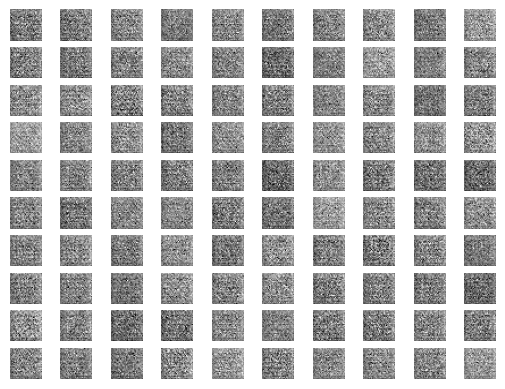

In [29]:
discriminator_final = build_discriminator()
generator_final = build_generator(latent_dim)
gan_model = build_GAN(generator_final, discriminator_final)
dataset = X
train(generator_final, discriminator_final, gan_model, dataset, latent_dim)